# Homework 4 Machine Learning and Applications

## Exercise 1 (5 points)

### Importing Packages and Data

In [26]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise, sklearn_selected, summarize, sklearn_selection_path, sklearn_sm)

from l0bnb import fit_path

In [3]:
ex1 = pd.read_csv('ex1.csv')

In [4]:
ex1.shape

(783, 12)

In [5]:
ex1.describe

<bound method NDFrame.describe of      income  hrs_work   race  age  gender citizen  time_to_work     lang  \
0      1700        40  other   35  female     yes            15    other   
1     45000        84  white   27    male     yes            40  english   
2      8600        23  white   69  female     yes             5  english   
3     33500        55  white   52    male     yes            20  english   
4      4000         8  white   67  female     yes            10  english   
..      ...       ...    ...  ...     ...     ...           ...      ...   
778   33300        40  white   54  female     yes            10  english   
779   85000        40  white   52    male     yes             8  english   
780   65000        48  white   53    male     yes            45  english   
781   70000        40  asian   63    male     yes            30  english   
782  105000        50  asian   36    male     yes            30  english   

    married          edu disability    birth_qrtr  
0

### OLS Regression
The most simple way to predict `income` in the `acs12` dataset is by manually picking an independent variable we believe is related to `income`, and running a simple OLS regression on all points in this dataset.

For example, I may believe that `age` is positively associated with `income`, in that older individuals would have higher income.

In [13]:
# defining outcome variable
y = ex1['income']
# bivariate linear regression
X = MS(['age']).fit_transform(ex1)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,10670.000,6333.943,1.684,0.093
age,804.138,139.720,5.755,0.000


Age is significantly positively correlated with income. Specifically, between two workers, the worker that is one year older will on average earn $804.1 annually than the younger worker.

In [14]:
print(f"model R2: {results.rsquared}\nmodel rss = {results.ssr}")

model R2: 0.04068692685727704
model rss = 2532440676902.695


However, despite the significant relationship between `age` and `income`, `age` can only explain 4% of the variation in annual income, so this first rendition of the model has too much bias to be useful in a real-world situation.

We can examine the predictive power of this first model further by splitting our data into training and test sets, and validating our findings with the trained model on unseen data. 

In [16]:
# splitting data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(ex1['age'], y, test_size = 0.25, random_state = 0)

In [17]:
# fitting regression model using training variables
model = sm.OLS(y_train, X_train)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
age,1036.3176,53.67,19.309,0.0


The magnitude of the `age` coefficient is greater in this model trained on a subset of the data, and remains statistically significant. 

In [18]:
valid_pred = results.predict(X_test)
# mean of squared errors
np.mean((y_test - valid_pred)**2)

2538590067.831983

In [22]:
train_pred = results.predict(X_train)
# training MSE
np.mean((y_train - train_pred)**2)

3482475022.8444157

In [21]:
import math
math.sqrt(np.mean((y_test - valid_pred)**2))

50384.42286889851

When used on unseen data, the model can predict `income` based on `age` with an average error of $50,384. The mean squared error (MSE) of this model is 2538590067.831983 on test data compared to 3482475022.8444157 for training data. This is a moderately performing model, but I am still not satisfied with the predictive error. To gain a more confident estimate of predictive accuracy before deciding on how to refine this model, I can use k-fold cross-validation to obtain an aggregate of test mean-squared error.

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 income   R-squared (uncentered):                   0.389
Model:                            OLS   Adj. R-squared (uncentered):              0.388
Method:                 Least Squares   F-statistic:                              372.8
Date:                Tue, 11 Mar 2025   Prob (F-statistic):                    1.16e-64
Time:                        14:39:05   Log-Likelihood:                         -7281.4
No. Observations:                 587   AIC:                                  1.456e+04
Df Residuals:                     586   BIC:                                  1.457e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age         1036.3176     53.670     19.309      0.000     930.908    1141.727
==============================================================================
Omnibus:                      476.822   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8021.992
Skew:                           3.617   Prob(JB):                         0.00
Kurtosis:                      19.603   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
cv_error = np.zeros(5)
acs_mod = sklearn_sm(sm.OLS)
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
acs_cv = cross_validate(acs_mod, X, y, cv = cv)
cv_err = np.mean(acs_cv['test_score'])
cv_err

3254979196.436643

This estimate represents the cross-validated error for this model's predictions of `income` using 10 folds. To refine this regression model and potentially improve its predictive accuracy, I can modify the coefficients through variable selection, shrinkage or dimension reduction. 

### Best/Stepwise Selection Methods

First, I go through all possible combinations of coefficients to find the subset of variables that produces the best performing model using the "best selection" method. 

First, I will simply find the best subset of variables using a model trained on all data observations.

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# taken from Geron text
acs = ex1.drop('income', axis = 1)
discrete = acs.select_dtypes(include = ['object']).columns
numeric = acs.select_dtypes(exclude = ['object']).columns
acs_pre = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(), discrete)
    ],
    remainder = 'passthrough'
)

acs_vars = acs_pre.fit_transform(ex1)
acs_df = pd.DataFrame(acs_vars, columns = acs_pre.get_feature_names_out())

In [40]:
acs_df

,onehot__race_asian,onehot__race_black,onehot__race_other,onehot__race_white,onehot__gender_female,onehot__gender_male,onehot__citizen_no,onehot__citizen_yes,onehot__lang_english,onehot__lang_other,...,onehot__disability_no,onehot__disability_yes,onehot__birth_qrtr_apr thru jun,onehot__birth_qrtr_jan thru mar,onehot__birth_qrtr_jul thru sep,onehot__birth_qrtr_oct thru dec,remainder__income,remainder__hrs_work,remainder__age,remainder__time_to_work
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1700.0,40.0,35.0,15.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,45000.0,84.0,27.0,40.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,8600.0,23.0,69.0,5.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,33500.0,55.0,52.0,20.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,4000.0,8.0,67.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,33300.0,40.0,54.0,10.0
779,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,85000.0,40.0,52.0,8.0
780,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,65000.0,48.0,53.0,45.0
781,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,70000.0,40.0,63.0,30.0


In [47]:


Xa = np.asarray(acs_vars)
path = fit_path(Xa, y.to_numpy(), max_nonzeros = Xa.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  1
Iteration: 5. Number of non-zeros:  1
Iteration: 6. Number of non-zeros:  1
Iteration: 7. Number of non-zeros:  1
Iteration: 8. Number of non-zeros:  1
Iteration: 9. Number of non-zeros:  1
Iteration: 10. Number of non-zeros:  1
Iteration: 11. Number of non-zeros:  1
Iteration: 12. Number of non-zeros:  1
Iteration: 13. Number of non-zeros:  1
Iteration: 14. Number of non-zeros:  1
Iteration: 15. Number of non-zeros:  1
Iteration: 16. Number of non-zeros:  1
Iteration: 17. Number of non-zeros:  1
Iteration: 18. Number of non-zeros:  1
Iteration: 19. Number of non-zeros:  1
Iteration: 20. Number of non-zeros:  1
Iteration: 21. Number of non-zeros:  1
Iteration: 22. Number of non-zeros:  1
Iteration: 23. Number of non-zeros:  1
Iteration: 24. Number of non-zeros:  1
Iteration: 25. Number of non-zeros:  1
I

{'B': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.98039216, 0.        , 0.        , 0.        ]),
 'B0': 886.0215861568067,
 'lambda_0': 2.2991213568278287e-05,
 'M': 1.1764705882352944,
 'Time_exceeded': False}

#### Forward Selection

First, we use AIC as the outcome statistic to optimize. 

In [49]:
# negative Cp
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    # p would be d in the equation above
    Yhat = estimator.predict(X)
    # residual sum of squares
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS + 2 * p * sigma2)/n

In [50]:
sigma2 = OLS(y, Xa).fit().scale

In [51]:
# last three arguments of nCp - estimator, X and Y
neg_Cp = partial(nCp, sigma2)
# neg_Cp is now the scorer for model selection

In [87]:
encode_acs = pd.get_dummies(ex1, columns = ['race', 'gender', 'citizen', 'lang', 'married',
                                            'edu', 'disability', 'birth_qrtr'], drop_first = True)


In [ ]:
# first peak is forward selection
design = MS(encode_acs.columns.drop('income')).fit(encode_acs)
strategy = Stepwise.first_peak(
    design, 
    direction = 'forward',
    max_terms = len(design.terms)
)

In [90]:
acs_Cp = sklearn_selected(
    OLS, strategy, scoring = neg_Cp
)
acs_Cp.fit(encode_acs, y)
acs_Cp.selected_state_

('age',
 'birth_qrtr_jan thru mar',
 'birth_qrtr_jul thru sep',
 'birth_qrtr_oct thru dec',
 'citizen_yes',
 'disability_yes',
 'edu_grad',
 'edu_hs or lower',
 'gender_male',
 'hrs_work',
 'lang_other',
 'married_yes',
 'race_black',
 'race_other',
 'race_white',
 'time_to_work')

In [93]:
strategy = Stepwise.first_peak(
    design, 
    direction = 'backwards',
    max_terms = len(design.terms)
)
acs_Cp = sklearn_selected(
    OLS, strategy, scoring = neg_Cp
)
acs_Cp.fit(encode_acs, y)
acs_Cp.selected_state_

('age',
 'birth_qrtr_jan thru mar',
 'birth_qrtr_jul thru sep',
 'birth_qrtr_oct thru dec',
 'citizen_yes',
 'disability_yes',
 'edu_grad',
 'edu_hs or lower',
 'gender_male',
 'hrs_work',
 'lang_other',
 'married_yes',
 'race_black',
 'race_other',
 'race_white',
 'time_to_work')

There are several limitations to this approach - sigma^2 is not a reliable performance indicator however MSE or R^2 would be biased because we only have training data. Validation or cross-validation approaches similarly apply and are highly beneficial to hyperparameter tuning through variable selection.

In [95]:
strategy = Stepwise.fixed_steps(
    design, len(design.terms), 
    direction = 'forward'
)
full_path = sklearn_selection_path(OLS, strategy)
#fit full path on Hittesr and compute predictions
full_path.fit(encode_acs, y)
Yhat_in = full_path.predict(encode_acs)
Yhat_in.shape

(783, 17)

In [98]:
K = 5
kfold = skm.KFold(
    K, random_state = 0, shuffle = True
)
Yhat_cv = skm.cross_val_predict(full_path, encode_acs, y, cv = kfold)
Yhat_cv.shape

(783, 17)

In [103]:
cv_mse = []
y = ex1['income'].to_numpy()
for train_idx, test_idx in kfold.split(y):
    errors = (Yhat_cv[test_idx]-y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(17, 5)

In [104]:
cv_mse

array([[2.76724250e+09, 3.43341962e+09, 2.47203751e+09, 5.44074157e+09,
        2.79029030e+09],
       [2.64704091e+09, 3.00803525e+09, 2.47233795e+09, 4.62329450e+09,
        2.04705889e+09],
       [2.32312768e+09, 2.73853059e+09, 2.33435509e+09, 4.14899436e+09,
        1.77344118e+09],
       [2.32395479e+09, 2.73464494e+09, 2.33031851e+09, 4.00104026e+09,
        1.79586879e+09],
       [2.19494375e+09, 2.60894533e+09, 2.22502970e+09, 3.90501612e+09,
        1.76737395e+09],
       [2.10465016e+09, 2.49385037e+09, 2.15723925e+09, 3.80969176e+09,
        1.76256695e+09],
       [2.13346935e+09, 2.53525667e+09, 2.11383053e+09, 3.84097155e+09,
        1.79561183e+09],
       [2.15334276e+09, 2.53678989e+09, 2.12003369e+09, 3.90617116e+09,
        1.76683158e+09],
       [2.16085673e+09, 2.49094897e+09, 2.11128161e+09, 3.90319550e+09,
        1.76633902e+09],
       [2.14807568e+09, 2.53250296e+09, 2.12548996e+09, 3.89654442e+09,
        1.74259706e+09],
       [2.15260142e+09, 2.5072

(2000000000.0, 4000000000.0)

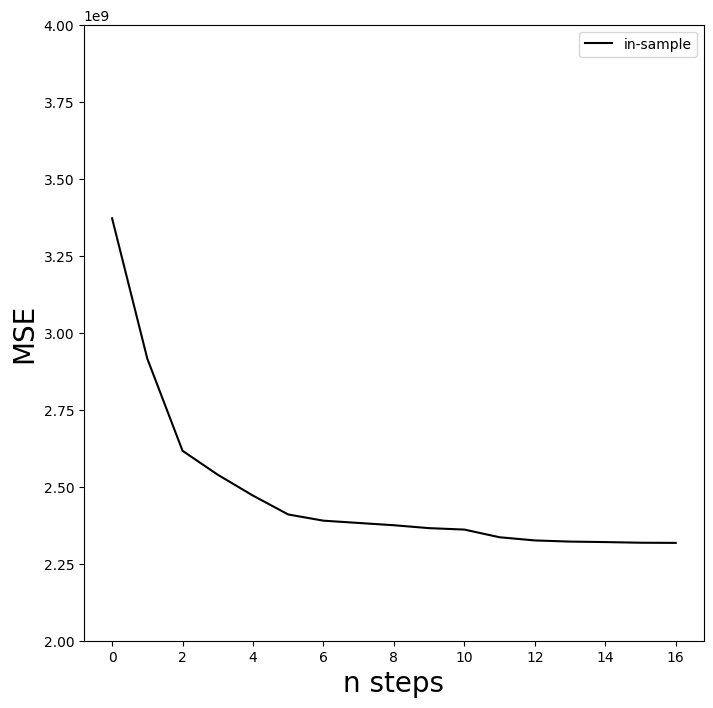

In [107]:
mse_fig, ax = subplots(figsize = (8, 8))
insample_mse = ((Yhat_in - y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(
    np.arange(n_steps),
    insample_mse,
    'k',
    label = 'in-sample'
)
ax.set_ylabel('MSE', fontsize = 20)
ax.set_xlabel('n steps', fontsize = 20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([2e9, 4e9])

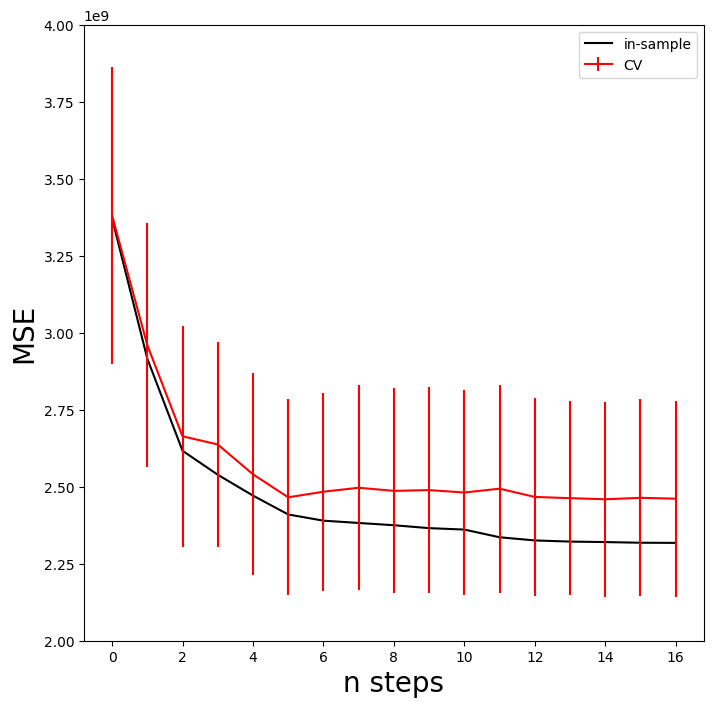

In [108]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(1),
    # standard error
    cv_mse.std(1)/np.sqrt(K),
    label = 'CV',
    c= 'r'
)
ax.set_ylim([2e9, 4e9])
ax.legend()
mse_fig

### Ridge Regression

In [122]:
D = design.transform(encode_acs)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [123]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs/X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / y.std()
soln_array = skl.ElasticNet.path(
    Xs, y, l1_ratio = 0, alphas = lambdas
)[1]
soln_array.shape

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2118927976955.9731, tolerance: 423863538.88
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages

(16, 100)

In [124]:
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns,
index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,hrs_work,age,time_to_work,race_black,race_other,race_white,gender_male,citizen_yes,lang_other,married_yes,edu_grad,edu_hs or lower,disability_yes,birth_qrtr_jan thru mar,birth_qrtr_jul thru sep,birth_qrtr_oct thru dec
negative log(lambda),,,,,,,,,,,,,,,,
-7.451376,11.473774,6.793416,2.961193,-2.708004,-2.692992,0.922931,7.852657,-0.734847,-0.490900,6.845422,12.383511,-10.210492,-2.456842,1.342019,0.431345,-0.685987
-7.218792,14.474647,8.569963,3.735470,-3.415967,-3.397158,1.163469,9.906497,-0.927611,-0.619212,8.634992,15.622303,-12.880596,-3.099634,1.692666,0.544334,-0.864958
-6.986207,18.259183,10.810316,4.711829,-4.308637,-4.285115,1.466320,12.496711,-1.171052,-0.780985,10.891430,19.706879,-16.247765,-3.910420,2.134679,0.686932,-1.090404
-6.753623,23.031326,13.635106,5.942790,-5.433983,-5.404638,1.847406,15.762903,-1.478557,-0.984901,13.735958,24.857345,-20.493280,-4.932999,2.691712,0.866906,-1.374266
-6.521038,29.047681,17.196063,7.494396,-6.852295,-6.815803,2.326584,19.880731,-1.867088,-1.241867,17.320934,31.350640,-25.845151,-6.222525,3.393460,1.094064,-1.731475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.644138,13083.762465,8230.168419,2005.854155,-10954.123541,-9448.504134,-12170.748290,8509.464539,-3155.817399,-4146.720759,2669.936017,14191.942841,-7830.311325,-3874.606175,885.200985,2260.375619,1996.426853
14.876722,13083.763469,8230.169251,2005.854166,-10954.131664,-9448.510490,-12170.758480,8509.464637,-3155.817500,-4146.723154,2669.935466,14191.943846,-7830.310764,-3874.606345,885.201089,2260.376149,1996.427394
15.109306,13083.764265,8230.169911,2005.854174,-10954.138100,-9448.515527,-12170.766554,8509.464715,-3155.817581,-4146.725052,2669.935030,14191.944643,-7830.310319,-3874.606479,885.201171,2260.376569,1996.427823


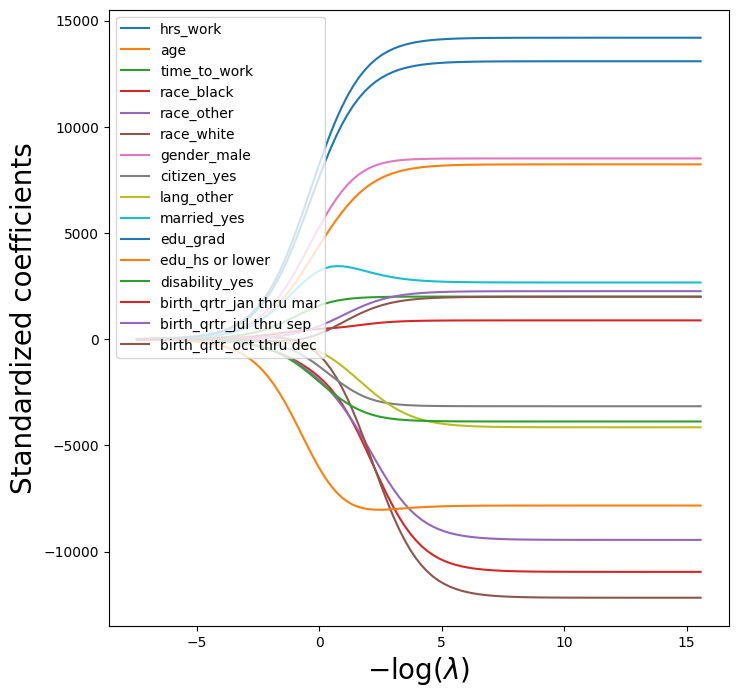

In [125]:



path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [126]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, y)
np.linalg.norm(ridge.coef_)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.081e+11, tolerance: 2.640e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


31333.163827213313

In [128]:
validation = skm.ShuffleSplit(
    n_splits = 1,
    test_size = 0.5, 
    random_state = 0
)

ridge.alpha = 0.01
results = skm.cross_validate(
    ridge, X, y, scoring = 'neg_mean_squared_error',
    cv = validation
)
-results['test_score']

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+11, tolerance: 1.450e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([2.37499438e+09])

In [129]:
param_grid = {'ridge__alpha':lambdas}
grid = skm.GridSearchCV(pipe, 
                        param_grid, 
                        cv=validation,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.247e+11, tolerance: 1.450e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.246e+11, tolerance: 1.450e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.6335019963265572, l1_ratio=0))])

In [130]:
# 5 fold cv
grid = skm.GridSearchCV(
    pipe, 
    param_grid, 
    cv = kfold, 
    scoring = 'neg_mean_squared_error'
)
grid.fit(X, y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+12, tolerance: 2.205e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+12, tolerance: 2.101e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.061893775837998335, l1_ratio=0))])

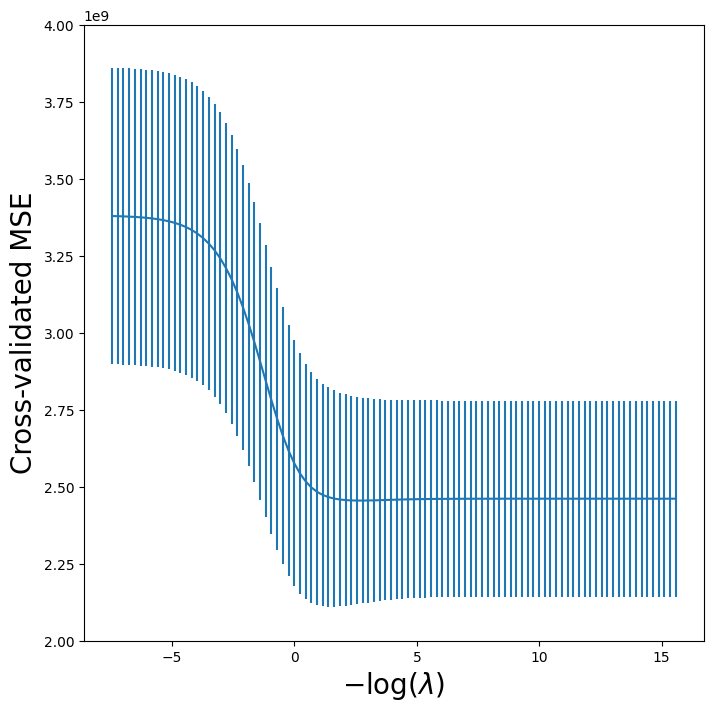

In [131]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([2e9,4e9])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [132]:
grid_r2 = skm.GridSearchCV(pipe,
param_grid,
cv=kfold)
grid_r2.fit(X, y)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+12, tolerance: 2.205e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+12, tolerance: 2.101e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=0.01, l1_ratio=0))]),
             param_grid={'ridge__alpha': array([1.72223108e+03, 1.36483868e+03, 1.08161131e+03, 8.57158466e+02,
       6.79283426e+02, 5.38320498e+02, 4.26609789e+02, 3.38080962e+02,
       2.67923380e+02, 2.12324697e+02, 1.68...
       3.62513134e-05, 2.87285459e-05, 2.27668813e-05, 1.80423641e-05,
       1.42982650e-05, 1.13311305e-05, 8.97972712e-06, 7.11628017e-06,
       5.63953034e-06, 4.46923135e-06, 3.54178941e-06, 2.80680754e-06,
       2.22434697e-06, 1.76275694e-06, 1.39695473e-06, 1.10706273e-06,
       8.77328281e-07, 6.95267659e-07, 5.50987729e-07, 4.36648353e-07,
       3.46036352e-07, 2.74227891e-07, 2.17320914e-07, 1.72223108e-07])})

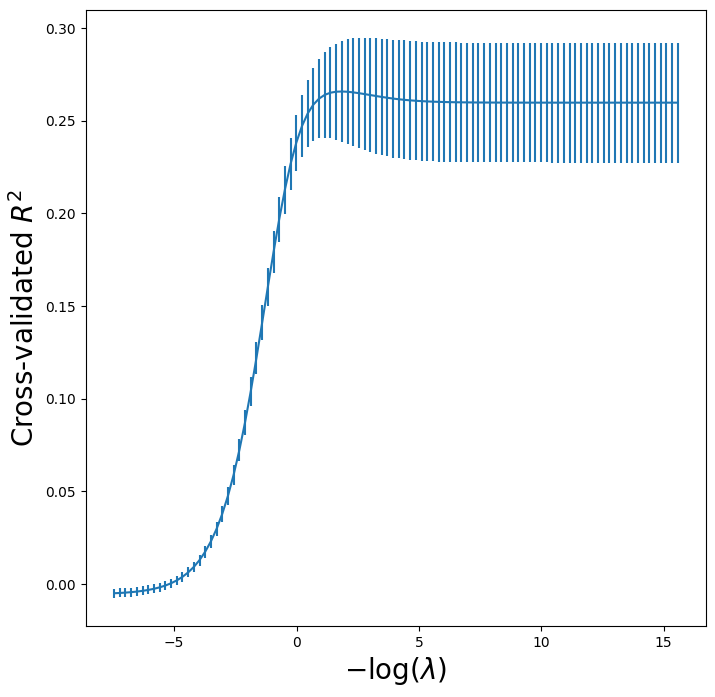

In [133]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
grid_r2.cv_results_['mean_test_score'],
yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

In [134]:
ridgeCV = skl.ElasticNetCV(
    alphas = lambdas,
    l1_ratio = 0, 
    cv= kfold
)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, y)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1102373119748.9202, tolerance: 220542164.08186892
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-pa

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.72223108e+03, 1.36483868e+03, 1.08161131e+03, 8.57158466e+02,
       6.79283426e+02, 5.38320498e+02, 4.26609789e+02, 3.38080962e+02,
       2.67923380e+02, 2.12324697e+02, 1.68263691e+02, 1.33346098e+02,
       1.05674502e+02, 8.37452357e+01, 6.63666671e+01, 5.25944487e+01,
       4.16802011e+01, 3.30308466e+01,...
       1.42982650e-05, 1.13311305e-05, 8.97972712e-06, 7.11628017e-06,
       5.63953034e-06, 4.46923135e-06, 3.54178941e-06, 2.80680754e-06,
       2.22434697e-06, 1.76275694e-06, 1.39695473e-06, 1.10706273e-06,
       8.77328281e-07, 6.95267659e-07, 5.50987729e-07, 4.36648353e-07,
       3.46036352e-07, 2.74227891e-07, 2.17320914e-07, 1.72223108e-07]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

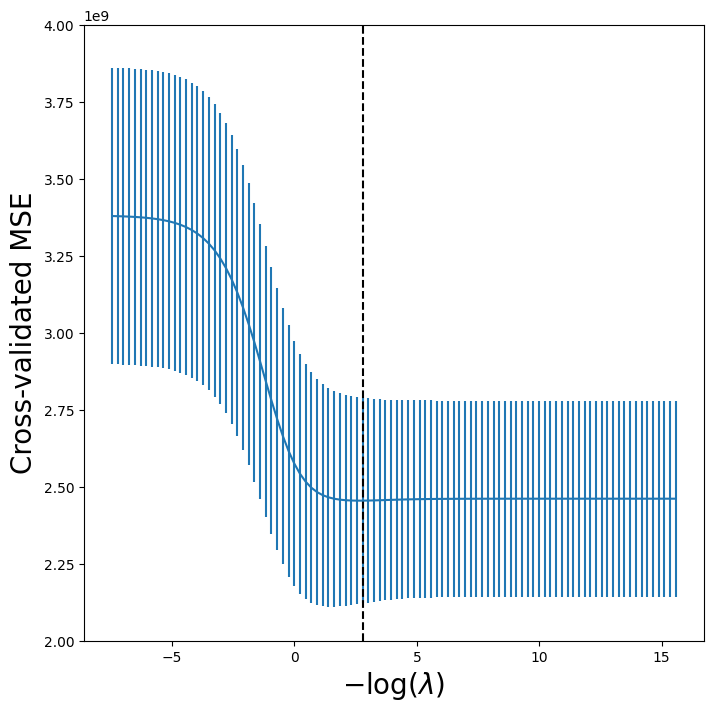

In [135]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([2e9, 4e9])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [136]:
outer_valid = skm.ShuffleSplit(n_splits=1,
test_size=0.25,
random_state=1)
inner_cv = skm.KFold(n_splits=5,
shuffle=True,
random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
l1_ratio=0,
cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
('ridge', ridgeCV)]);

In [137]:
results = skm.cross_validate(pipeCV,
X,
y,
cv=outer_valid,
scoring='neg_mean_squared_error')
-results['test_score']

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 841260127021.1354, tolerance: 168299678.77445632
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/abigaillee/Library/Python/3.9/lib/python/site-pac

array([2.24491203e+09])

In [138]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
l1_ratio=1,
cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
('lasso', lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

56.70137681039615

In [139]:
lambdas , soln_array = skl.Lasso.path(Xs,
y,
l1_ratio=1,
n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns,
index=-np.log(lambdas))

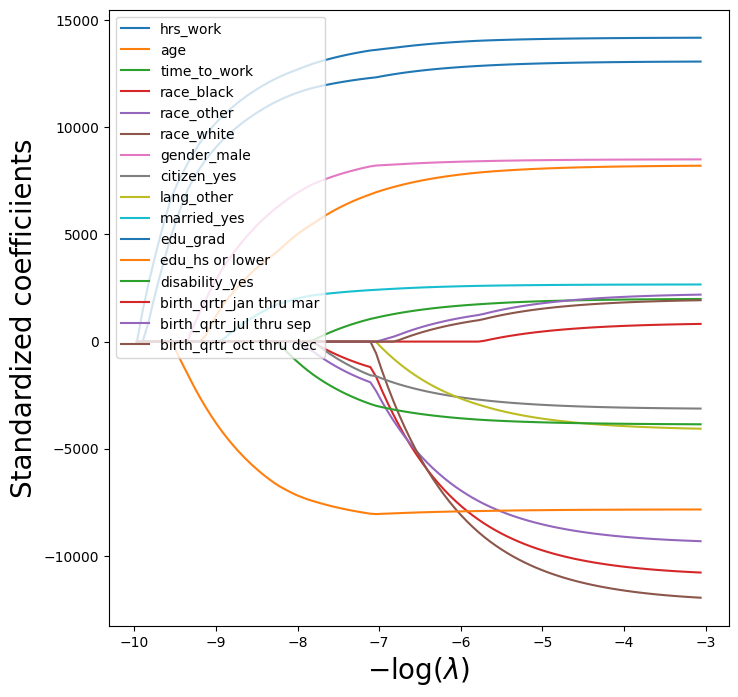

In [140]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

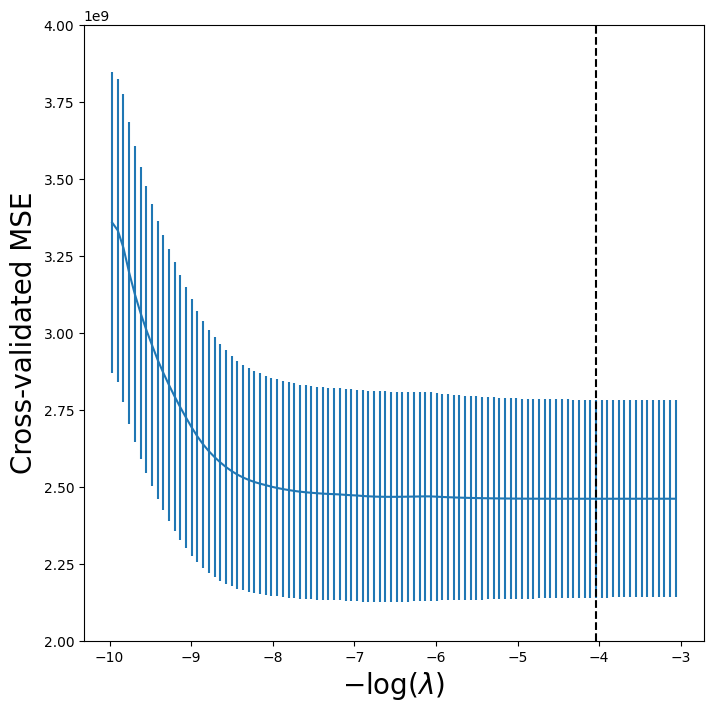

In [141]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([2e9, 4e9])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

### PCA

In [142]:
pca = PCA(n_components = 2)
# first manually specifying n of components
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, y)
pipe.named_steps['linreg'].coef_

array([ 286.86338055, 1031.87529681])

In [143]:
# results depend on standardisation
pipe = Pipeline([('scaler', scaler),
('pca', pca),
('linreg', linreg)])
pipe.fit(X, y)
pipe.named_steps['linreg'].coef_

array([ 8855.09978907, 19539.88708208])

In [144]:
# hyperparameter tuning using cross-validation approach
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
param_grid,
cv=kfold,
scoring='neg_mean_squared_error')
grid.fit(X, y)

/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/abigaillee/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 654, in fit
    

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

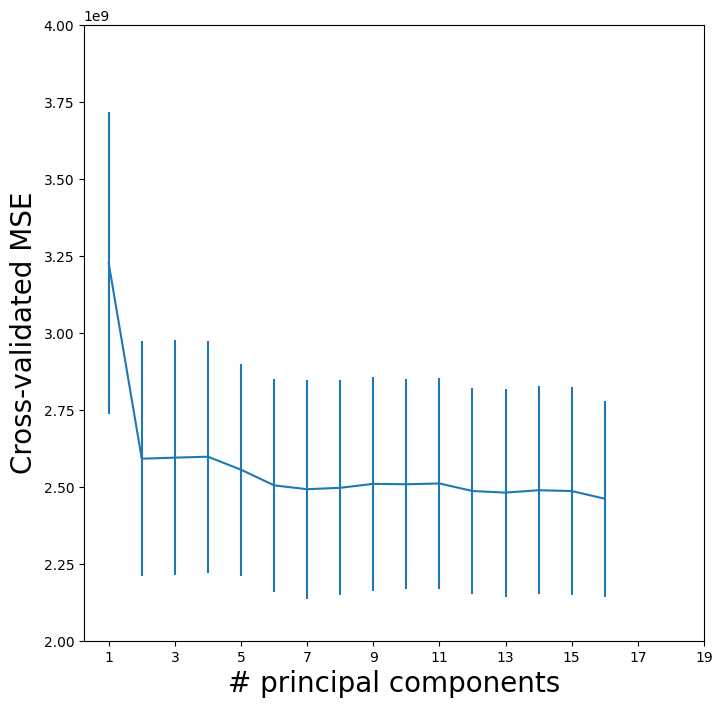

In [145]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([2e9, 4e9]);